# Fotometria de Apertura: Sextans A
# Juan David Galan Vargas - 202111470

In [1]:
from glob import glob
from astropy.io import fits
from astropy.visualization import hist
from astropy.modeling import fitting
from astropy.modeling.models import custom_model
fitter = fitting.LevMarLSQFitter()

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
import scipy.ndimage as ndi
import astropy.stats as astrostats
from sklearn.neighbors import NearestNeighbors
from photutils.aperture import CircularAnnulus

# configuration
np.set_printoptions(linewidth=120) # para que se vea

cmap = plt.get_cmap("inferno")
cmap.set_bad(color="r")
cmap.set_over(color="w")
if "astro" in plt.colormaps():
    colormaps.unregister("astro")
colormaps.register(cmap,name="astro")
plt.rcParams["image.origin"] = "lower"
plt.rcParams["image.cmap"] = "astro"
plt.rcParams["figure.figsize"] = (10,5)
plt.rcParams["axes.labelsize"] = 15



def quantile_linspace(arr,num=100,lower=0.01,upper=0.99):
    return np.linspace(*np.quantile(np.ravel(arr),[lower,upper]),num=num)

def quantile_imshow(img,lower=0.01,upper=0.99,**kwargs):
    img_vmin = np.quantile(img,lower)
    img_vmax = np.quantile(img,upper)
    return plt.imshow(img,vmin=img_vmin,vmax=img_vmax,**kwargs)

def quantile_hist(data,num=100,lower=0.01,upper=0.99):
    return plt.hist(np.ravel(data),bins=quantile_linspace(np.ravel(data),num,lower,upper))

def pseudomode(arr,sigma=1.6,maxiters=20):
    masked = astrostats.sigma_clip(arr,sigma=sigma,maxiters=maxiters)
    return arr[~masked.mask].mean()

In [2]:
glob("*")

['1sextansA_mask.fits',
 'aperture_photometry_1.ipynb',
 'datos',
 'Fotometria General.ipynb',
 'Fotometria.ipynb',
 'graficas',
 'graficas sextans',
 'Imagenes Reducidos',
 'Lab5.ipynb',
 'sextansA_mask.fits',
 'sextansA_PSF.npy']

In [3]:
hdul = fits.open("datos\sextans_A.fits");
images = {hdu.name:hdu.data.astype(float) for hdu in hdul}
headers = {hdu.name:hdu.header for hdu in hdul}
names = ["U", "B", "V", "R", "I", "HALPHA", "OIII", "SII"]
img = []
for name in names:
    img.append(images[name])
hdul.close()

In [4]:
headers

{'B': SIMPLE  =                    T / Fits standard                                  
 BITPIX  =                  -32 / Bits per pixel                                 
 NAXIS   =                    2 / Number of axes                                 
 NAXIS1  =                 1701 / Axis length                                    
 NAXIS2  =                 1501 / Axis length                                    
 EXTEND  =                    T / File may contain extensions                    
 ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        
 DATE    = '2015-07-24T20:23:18' / Date FITS file was generated                  
 IRAF-TLM= '2015-07-24T20:23:18' / Time of last modification                     
 OBJECT  = 'SextansA B'         / Name of the object observed                    
 FILENAME= 'obj151  '           / Original host filename                         
 OBSTYPE = 'object  '           / Observation type                               
 PREFLASH= 

In [5]:
hdul1 = fits.open("1sextansA_mask.fits");
image = {hdu.name:hdu.data.astype(float) for hdu in hdul1} #image is the mask img
headers1 = {hdu.name:hdu.header for hdu in hdul1}
hdul.close()

In [6]:
headers1

{'PRIMARY': SIMPLE  =                    T / conforms to FITS standard                      
 BITPIX  =                   64 / array data type                                
 NAXIS   =                    2 / number of array dimensions                     
 NAXIS1  =                 1701                                                  
 NAXIS2  =                 1501                                                  
 EXTEND  =                    T                                                  }

In [7]:
mask = image['PRIMARY'].astype('int64')

In [8]:
from skimage.feature import peak_local_max
from photutils.centroids import centroid_sources, centroid_quadratic


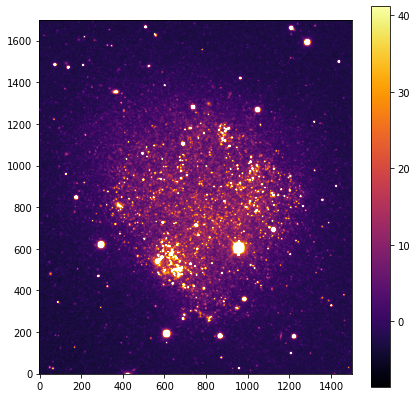

In [9]:
plt.figure(figsize=(7,7))
quantile_imshow(img[2].T)
plt.colorbar()

[8.289942741394043, 5.31157922744751, 6.996328830718994, 14.894094467163086]

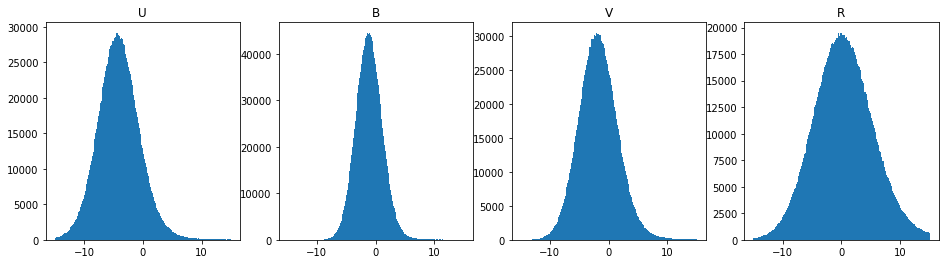

In [10]:
fig,ax = plt.subplots(ncols=4, figsize=(16,4))
for i in range(len(img[0:4])):
    plt.sca(ax[i])
    plt.hist(img[i][mask==1].ravel(),np.linspace(-15,15,200))
    plt.title(names[i])

thresh = []
for i in range(len(img[0:4])):
    thresh.append(np.quantile(img[i].ravel(),0.85 ))
thresh

In [11]:
# threshold_abs=thresh[i]+(thresh[i]*11)
peaks = []
for i, imgs in enumerate(img[0:4]):
    peaks.append(peak_local_max(ndi.gaussian_filter(imgs,2),threshold_abs=thresh[i]*5,labels=mask.astype(int),exclude_border=30))

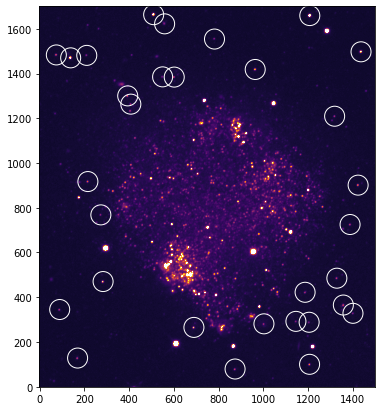

In [12]:
plt.figure(figsize=(7,7))
plt.imshow(img[0].T,vmax=200)
plt.scatter(*peaks[0].T, fc="none",ec="w", s=400)


In [13]:
from PIL import Image
#img = Image.open(0);

In [14]:
#mask = (np.array(img))

Text(0.5, 0, 'Distance correction [pix]')

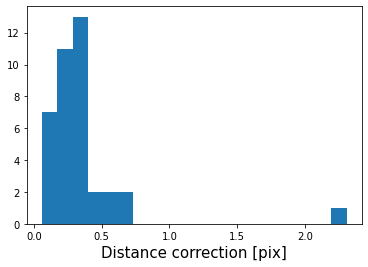

In [15]:
centroids=[]
distances=[]
for i in range(len(img[0:4])):
    centroid = np.array(
        centroid_sources((img[i]-img[i].mean()).T,*peaks[i].T,centroid_func=centroid_quadratic,box_size=9)).T
    distance = np.hypot(*(peaks[i]-centroid).T)
    centroids.append(centroid)
    distances.append(distance)
plt.hist(distances[3],bins=20)
plt.xlabel("Distance correction [pix]")


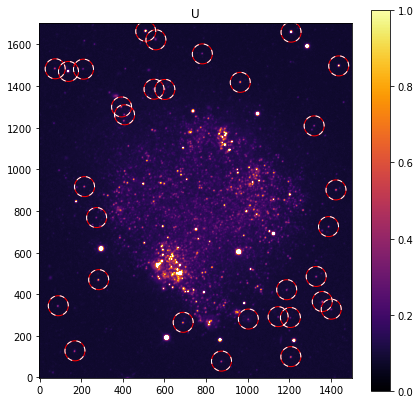

In [16]:
plt.figure(figsize=(7,7))
plt.imshow(img[0].T,vmax=200)
plt.scatter(*centroids[0].T,fc="none",ec="r",s=400)
plt.scatter(*peaks[0].T,fc="none",ec="w",s=400,linestyle=(5,(5,5)))
plt.title("U")
plt.colorbar()
plt.show()

In [17]:
from photutils.aperture import CircularAperture, ApertureStats
from photutils.profiles import RadialProfile
from astropy.modeling.models import Gaussian1D,Voigt1D,Const1D
from astropy.modeling.fitting import LevMarLSQFitter
fitter = LevMarLSQFitter(calc_uncertainties=True)
import math

In [18]:
import numpy as np
def remove_nan_coordinates(coord_array):
    return coord_array[~np.isnan(coord_array).any(axis=1)]


In [19]:
len(centroids[0][0])

2

In [20]:
nombres={0:"U",1:"B", 2:"V", 3:"R"}

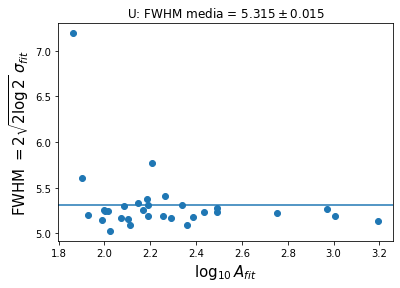

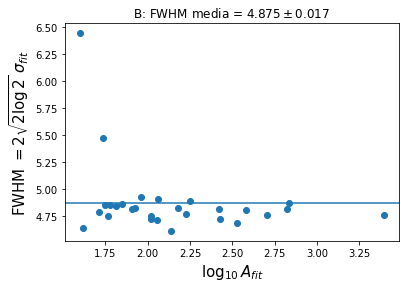

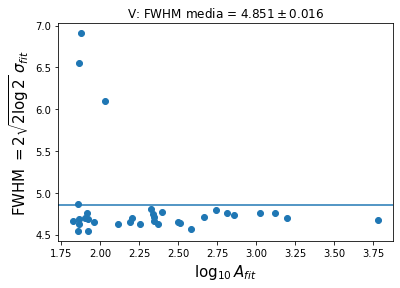

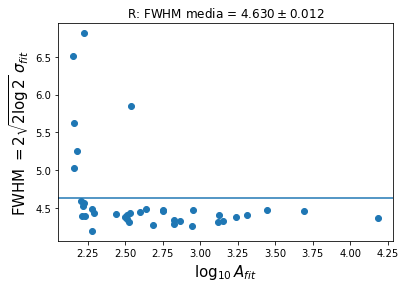

In [21]:
FWHM=[]
FWHM_err=[]

for i in range(len(img[0:4])):
    centroids[i]=remove_nan_coordinates(centroids[i])


for i in range(len(img[0:4])):
    model = Const1D(100) + Gaussian1D(5e3,0,1.5)
    model.mean_1.fixed = True
    radii = np.arange(0,10,1)
    profile = RadialProfile(img[i].T,centroids[i][0],radii)
    fitted_model = fitter(model,profile.radius,profile.profile)
    params = []
    params_std = []
    for c in centroids[i]:
        try:
            profile = RadialProfile(img[i].T,c,radii)
            fitted_model = fitter(model,profile.radius,profile.profile)
            params_std.append(np.sqrt(np.diag(fitter.fit_info["param_cov"])))
            params.append(fitted_model.parameters)
        except ValueError:
            pass
    params = np.asarray(params)
    params_std = np.asarray(params_std)
    x = np.log10(params.T[1])
    y = 2*np.sqrt(2*np.log(2))*params.T[3]


    dx = params_std.T[1]/params.T[1] / np.log(10)
    dy = 2*np.sqrt(2*np.log(2))*params_std.T[2]
    samples = np.random.normal(loc=y,scale=dy,size=(10_000,len(y)))
    means = samples.mean(axis=1)
    FWHM_s = means.mean()
    FWHM_err_s = means.std()
    FWHM.append(FWHM_s)
    FWHM_err.append(FWHM_err_s)
    #plt.errorbar(x,y,dy,dx,fmt=". k",capsize=4)
    plt.scatter(x,y)
    plt.xlabel("$\\log_{10} A_{fit}$")
    plt.ylabel("FWHM $= 2\\sqrt{2\\log 2}\\;\\sigma_{fit}$")
    plt.axhline(FWHM_s)
    plt.title(nombres[i]+": "+f"FWHM media = ${FWHM_s:.3f}\\pm{FWHM_err_s:.3f}$")
    plt.show()


7.972094806225355
29.964915236567908


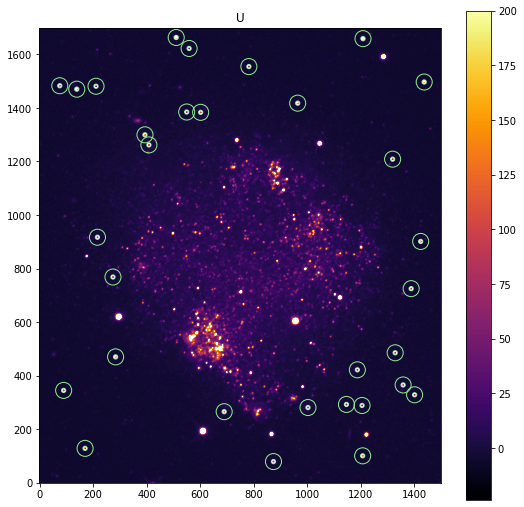

7.3120161228379255
43.045873108794964


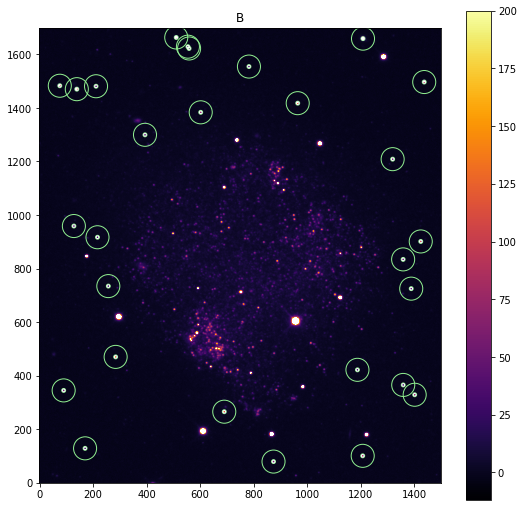

7.276564240096661
12.770750342422492


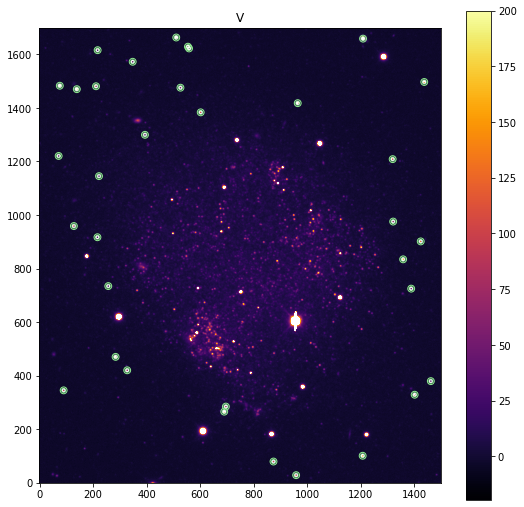

6.9454047588497225
12.920401448617385


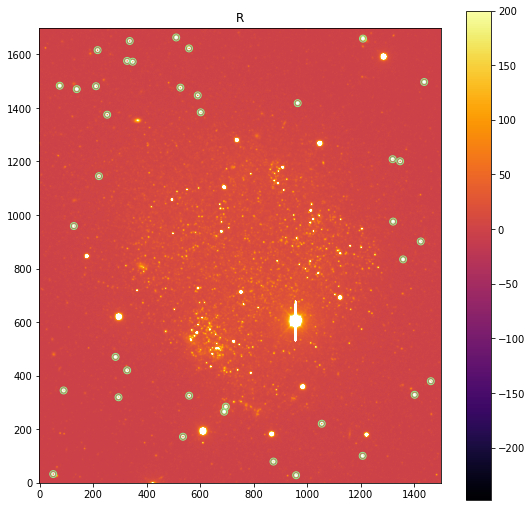

In [22]:
sky_apertures=[]
star_apertures=[]
for i in range(len(img[0:4])):
    min_distance=NearestNeighbors(n_neighbors=2).fit(centroids[i]).kneighbors(centroids[i])[0][:,1].min()

    if 1.5*FWHM[i]>(min_distance-FWHM[i])*0.85:
        distancias=NearestNeighbors(n_neighbors=2).fit(centroids[i]).kneighbors(centroids[i])[0][:,1]
        distancias=np.sort(distancias)
        for elem in distancias:
            if elem != min_distance:
                min_distance = elem
                break
    print(1.5*FWHM[i])
    print((min_distance-FWHM[i])*0.85)
    sky_aperture=CircularAnnulus(centroids[i],1.5*FWHM[i],0.85*(min_distance-FWHM[i]))
    star_aperture=CircularAperture(centroids[i],FWHM[i])
    sky_apertures.append(sky_aperture)
    star_apertures.append(star_aperture)
    plt.figure(figsize=(9,9))
    plt.imshow(img[i].T,vmax=200)
    sky_aperture.plot(color="lightgreen")
    star_aperture.plot(color="w")
    plt.title(nombres[i])
    plt.colorbar()
    plt.show()

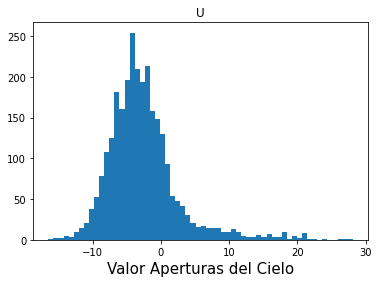

1.3406962036473633


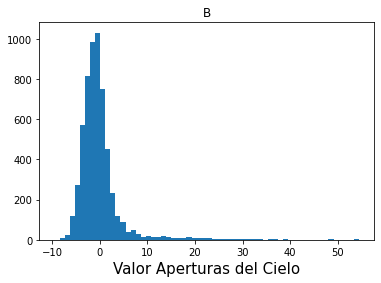

0.6575241333275854


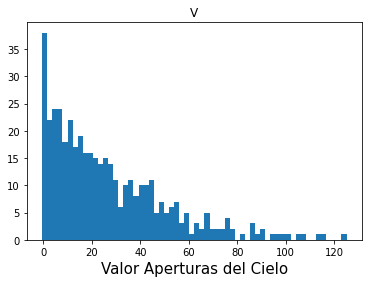

4.719998519476988


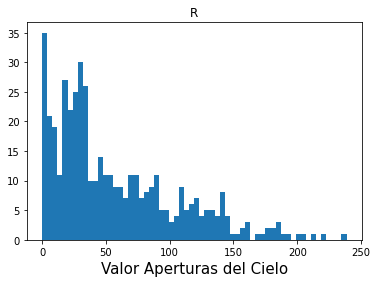

9.244250948565282


In [67]:
sky_values=[]
star_values=[]
errores=[]
for i in range(len(img[0:4])):
    sky_value=ApertureStats(img[i].T,sky_apertures[i]).median
    star_value=ApertureStats(img[i].T,star_apertures[i]).sum/star_apertures[i].area
    sky_values_err = (ApertureStats(img[i].T,sky_apertures[i], sigma_clip=astrostats.SigmaClip()).median)
    star_values_err =(ApertureStats(img[i].T, star_apertures[i]).sum / star_apertures[i].area)
    sky_values.append(sky_value)
    star_values.append(star_value)
    sky=sky_apertures[i][0].to_mask().get_values(img[i].T)
    plt.hist(sky,60)
    plt.xlabel("Valor Aperturas del Cielo")
    plt.title(nombres[i])
    plt.show()
    print(np.std(sky_value))
    error=(5/2)*(1/np.log(10))*(np.sqrt((np.std(star_value)**2)-(np.std(sky_value)**2))/abs(sky_value-star_value))
    errores.append(error)


31


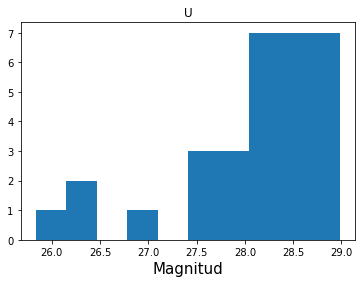

28


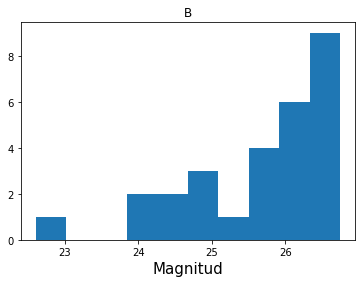

34


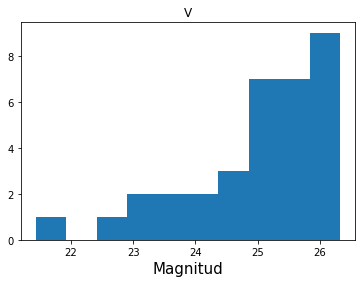

38


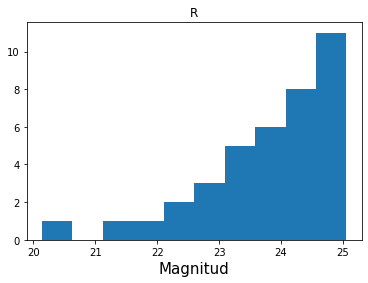

In [68]:
k=[0.6,0.4,0.2,0.1]
magnitudes=[]
for i in range(len(img[0:4])):
    mag_instr=-2.5*np.log10((star_values[i]-sky_values[i])/headers[nombres[i]]["EXPTIME"])+25
    masa_aire=headers[nombres[i]]["AIRMASS"]
    mag_instr=mag_instr+(masa_aire*k[i])
    print(len(mag_instr))
    plt.hist(mag_instr)
    magnitudes.append(mag_instr)
    plt.title(nombres[i])
    plt.xlabel("Magnitud")
    plt.show()


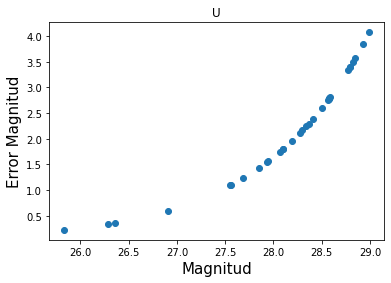

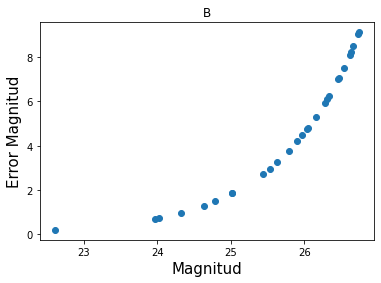

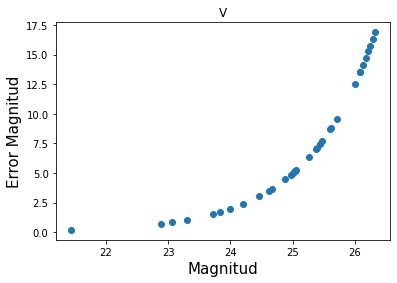

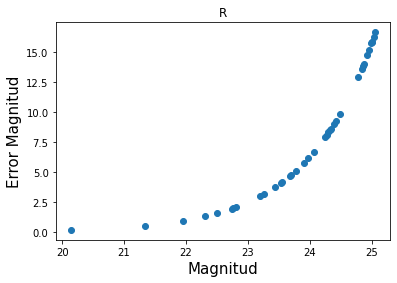

In [71]:
for i in range(len(img[0:4])):
    plt.scatter(magnitudes[i],errores[i])
    plt.title(nombres[i])
    plt.xlabel("Magnitud")
    plt.ylabel("Error Magnitud")
    plt.show()

In [ ]:
#min_distance=NearestNeighbors(n_neighbors=2).fit(centroids[i]).kneighbors(centroids[i])[0][:,1].min()
f=NearestNeighbors(n_neighbors=1).fit(centroids[2])#.kneighbors(centroids[1])[0]#[:,1].min()
dist, idx= f.kneighbors(centroids[1])
dist=dist[:,0]
idx=idx[:,0]

In [ ]:
import pandas as pd

In [ ]:
df=pd.DataFrame({"B":magnitudes[1],"V":magnitudes[2][idx],"dist":dist})
df

,B,V,dist
0,22.606710,21.436838,0.139631
1,23.968655,23.063059,0.045267
2,24.022285,23.299833,0.030542
3,24.325510,22.886663,0.048038
4,24.632223,23.830522,0.185989
5,24.788115,23.724544,0.021549
6,25.016422,23.993952,0.189809
7,25.021720,24.204848,0.151910
8,25.435678,25.043177,0.203205
9,25.526706,24.618850,0.328952


In [ ]:
df=df.query("dist<0.5")
df

,B,V,dist
0,22.606710,21.436838,0.139631
1,23.968655,23.063059,0.045267
2,24.022285,23.299833,0.030542
3,24.325510,22.886663,0.048038
4,24.632223,23.830522,0.185989
5,24.788115,23.724544,0.021549
6,25.016422,23.993952,0.189809
7,25.021720,24.204848,0.151910
8,25.435678,25.043177,0.203205
9,25.526706,24.618850,0.328952


In [73]:
len(df)

24

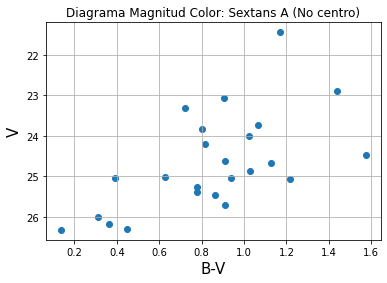

In [72]:
plt.scatter(df.B-df.V, df.V)
plt.gca().invert_yaxis()
plt.xlabel("B-V")
plt.ylabel("V")
plt.title("Diagrama Magnitud Color: Sextans A (No centro)")
plt.grid(True)